In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention - The core of transformer architecture
    This is where the magic happens!
    """
    
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        # Linear transformations for Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

In [5]:
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        """
        The attention mechanism: Attention(Q,K,V) = softmax(QK^T/√d_k)V
        """
        # Calculate attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        
        # Apply mask if provided (for causal attention in GPT)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        # Apply softmax to get attention weights
        attention_weights = F.softmax(scores, dim=-1)
        
        # Apply attention to values
        output = torch.matmul(attention_weights, V)
        
        return output, attention_weights

In [6]:
 def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        # 1. Linear transformations and split into heads
        Q = self.W_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        # 2. Apply attention
        attention_output, attention_weights = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # 3. Concatenate heads
        attention_output = attention_output.transpose(1, 2).contiguous().view(
            batch_size, -1, self.d_model
        )
        
        # 4. Final linear transformation
        output = self.W_o(attention_output)
        
        return output, attention_weights

In [9]:
class PositionalEncoding(nn.Module):
    """
    Positional encoding to give the model information about token positions
    Since transformers have no inherent notion of sequence order
    """
    
    def __init__(self, d_model, max_length=5000):
        super().__init__()
        
        pe = torch.zeros(max_length, d_model)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        
        # Create sinusoidal patterns
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)  # Even positions
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd positions
        
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

        def forward(self, x):
            return x + self.pe[:x.size(0), :]

In [11]:
class TransformerBlock(nn.Module):
    """
    A single transformer block (encoder layer)
    """
    
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        
        # Multi-head attention
        self.attention = MultiHeadAttention(d_model, num_heads)
        
        # Feed-forward network
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        
        # Layer normalization and dropout
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        # Self-attention with residual connection
        attn_output, attention_weights = self.attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        # Feed-forward with residual connection
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        
        return x, attention_weights

In [12]:
class SimpleTransformer(nn.Module):
    """
    A simplified transformer for educational purposes
    """
    
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_length=1000):
        super().__init__()
        
        # Token embeddings
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_length)
        
        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff)
            for _ in range(num_layers)
        ])
        
        # Output layer
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size)
        
        self.d_model = d_model
    
    def forward(self, x, mask=None):
        # Token embeddings + positional encoding
        x = self.embedding(x) * np.sqrt(self.d_model)
        x = self.positional_encoding(x)
        
        # Pass through transformer blocks
        attention_weights = []
        for transformer_block in self.transformer_blocks:
            x, weights = transformer_block(x, mask)
            attention_weights.append(weights)
        
        # Final layer norm and projection
        x = self.ln_f(x)
        logits = self.head(x)
        
        return logits, attention_weights

In [13]:
def visualize_attention_patterns():
    """
    Visualize how attention works with a simple example
    """
    print("=== Understanding Attention Mechanism ===\n")
    
    # Create a simple example
    sentences = [
        "The cat sat on the mat",
        "The quick brown fox jumps over the lazy dog",
        "Transformers revolutionized natural language processing"
    ]
    
    # Simulate attention weights for demonstration
    def create_mock_attention(sentence):
        words = sentence.split()
        n = len(words)
        # Create realistic-looking attention pattern
        attention = np.random.rand(n, n)
        
        # Make attention focus more on relevant words
        for i in range(n):
            # Self-attention (diagonal)
            attention[i, i] += 0.5
            # Attention to adjacent words
            if i > 0:
                attention[i, i-1] += 0.3
            if i < n-1:
                attention[i, i+1] += 0.3
        
        # Normalize to create proper attention weights
        attention = attention / attention.sum(axis=1, keepdims=True)
        return attention, words
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for idx, sentence in enumerate(sentences):
        attention, words = create_mock_attention(sentence)
        
        # Create heatmap
        sns.heatmap(attention, 
                   xticklabels=words, 
                   yticklabels=words,
                   annot=True, 
                   fmt='.2f',
                   cmap='Blues',
                   ax=axes[idx])
        
        axes[idx].set_title(f'Attention Pattern: "{sentence}"')
        axes[idx].set_xlabel('Keys (attending to)')
        axes[idx].set_ylabel('Queries (attending from)')
    
    plt.tight_layout()
    plt.show()
    
    print("Key Insights from Attention Visualization:")
    print("1. Each word (query) attends to all words (keys) with different weights")
    print("2. Attention weights sum to 1 for each query")
    print("3. The model learns which words are relevant to each other")
    print("4. This allows capturing long-range dependencies\n")


In [14]:
def demonstrate_positional_encoding():
    """
    Show why and how positional encoding works
    """
    print("=== Positional Encoding Visualization ===\n")
    
    d_model = 512
    max_length = 100
    
    # Create positional encoding
    pe = PositionalEncoding(d_model, max_length)
    
    # Get the encoding matrix
    pos_encoding = pe.pe[:max_length, :].squeeze().numpy()
    
    # Visualize
    plt.figure(figsize=(15, 8))
    
    plt.subplot(2, 2, 1)
    plt.imshow(pos_encoding[:50, :50], cmap='RdBu', aspect='auto')
    plt.title('Positional Encoding Heatmap (first 50 positions and dimensions)')
    plt.xlabel('Dimension')
    plt.ylabel('Position')
    plt.colorbar()
    
    plt.subplot(2, 2, 2)
    # Show how different dimensions encode position differently
    positions = range(50)
    plt.plot(positions, pos_encoding[:50, 0], label='Dimension 0')
    plt.plot(positions, pos_encoding[:50, 1], label='Dimension 1')
    plt.plot(positions, pos_encoding[:50, 10], label='Dimension 10')
    plt.plot(positions, pos_encoding[:50, 50], label='Dimension 50')
    plt.title('Positional Encoding Patterns')
    plt.xlabel('Position')
    plt.ylabel('Encoding Value')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 2, 3)
    # Show the sinusoidal nature
    dim_to_show = [0, 1, 2, 3]
    for dim in dim_to_show:
        plt.plot(range(100), pos_encoding[:100, dim], 
                label=f'Dim {dim} ({"sin" if dim % 2 == 0 else "cos"})')
    plt.title('Sinusoidal Patterns in Positional Encoding')
    plt.xlabel('Position')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 2, 4)
    # Show frequency differences
    freqs = 1 / (10000 ** (np.arange(0, d_model, 2) / d_model))
    plt.loglog(range(len(freqs)), freqs)
    plt.title('Frequencies Used in Positional Encoding')
    plt.xlabel('Dimension Pair')
    plt.ylabel('Frequency')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print("Why Positional Encoding is Crucial:")
    print("1. Transformers process all positions simultaneously")
    print("2. Without position info, 'cat sat on mat' = 'mat on sat cat'")
    print("3. Sinusoidal encoding allows the model to attend to relative positions")
    print("4. Different frequencies encode position at different scales\n")

In [15]:
def compare_architectures():
    """
    Compare different architectures leading to transformers
    """
    print("=== Architecture Evolution Comparison ===\n")
    
    architectures = {
        'RNN': {
            'pros': ['Can handle variable length', 'Memory of past'],
            'cons': ['Sequential processing', 'Vanishing gradients', 'No parallelization'],
            'use_case': 'Early language modeling'
        },
        'LSTM/GRU': {
            'pros': ['Better long-term memory', 'Solves vanishing gradients'],
            'cons': ['Still sequential', 'Complex gating', 'Limited parallelization'],
            'use_case': 'Machine translation (pre-attention)'
        },
        'CNN + Attention': {
            'pros': ['Parallel processing', 'Local patterns', 'Some attention'],
            'cons': ['Limited receptive field', 'Not optimized for sequences'],
            'use_case': 'Computer vision, some NLP'
        },
        'Transformer': {
            'pros': ['Full parallelization', 'Long-range dependencies', 'Scalable', 'Transfer learning'],
            'cons': ['Quadratic memory complexity', 'No inherent inductive biases'],
            'use_case': 'Modern NLP, vision, multimodal'
        }
    }
    
    for arch, details in architectures.items():
        print(f"{arch}:")
        print(f"  Pros: {', '.join(details['pros'])}")
        print(f"  Cons: {', '.join(details['cons'])}")
        print(f"  Primary use: {details['use_case']}")
        print()

In [16]:
def transformer_learning_path():
    """
    Complete learning path for understanding transformers
    """
    print("🚀 TRANSFORMER LEARNING PATH")
    print("=" * 50)
    
    print("\n📚 STEP 1: Understand the Problem")
    print("- Why RNNs were limited")
    print("- The need for parallelization")
    print("- Long-range dependency challenge")
    
    print("\n🔍 STEP 2: Attention Mechanism")
    print("- Query, Key, Value concept")
    print("- Scaled dot-product attention")
    print("- Multi-head attention benefits")
    
    print("\n📍 STEP 3: Positional Information")
    print("- Why position matters")
    print("- Sinusoidal encoding design")
    print("- Learned vs fixed encodings")
    
    print("\n🏗️ STEP 4: Architecture Components")
    print("- Layer normalization")
    print("- Residual connections")
    print("- Feed-forward networks")
    
    print("\n🎯 STEP 5: Training Insights")
    print("- Teacher forcing")
    print("- Causal masking")
    print("- Optimization challenges")
    
    print("\n🚀 STEP 6: Scaling Laws")
    print("- Parameter scaling")
    print("- Data scaling")
    print("- Compute scaling")


Starting Transformer Architecture Deep Dive...

🚀 TRANSFORMER LEARNING PATH

📚 STEP 1: Understand the Problem
- Why RNNs were limited
- The need for parallelization
- Long-range dependency challenge

🔍 STEP 2: Attention Mechanism
- Query, Key, Value concept
- Scaled dot-product attention
- Multi-head attention benefits

📍 STEP 3: Positional Information
- Why position matters
- Sinusoidal encoding design
- Learned vs fixed encodings

🏗️ STEP 4: Architecture Components
- Layer normalization
- Residual connections
- Feed-forward networks

🎯 STEP 5: Training Insights
- Teacher forcing
- Causal masking
- Optimization challenges

🚀 STEP 6: Scaling Laws
- Parameter scaling
- Data scaling
- Compute scaling


=== Architecture Evolution Comparison ===

RNN:
  Pros: Can handle variable length, Memory of past
  Cons: Sequential processing, Vanishing gradients, No parallelization
  Primary use: Early language modeling

LSTM/GRU:
  Pros: Better long-term memory, Solves vanishing gradients
  Cons: St

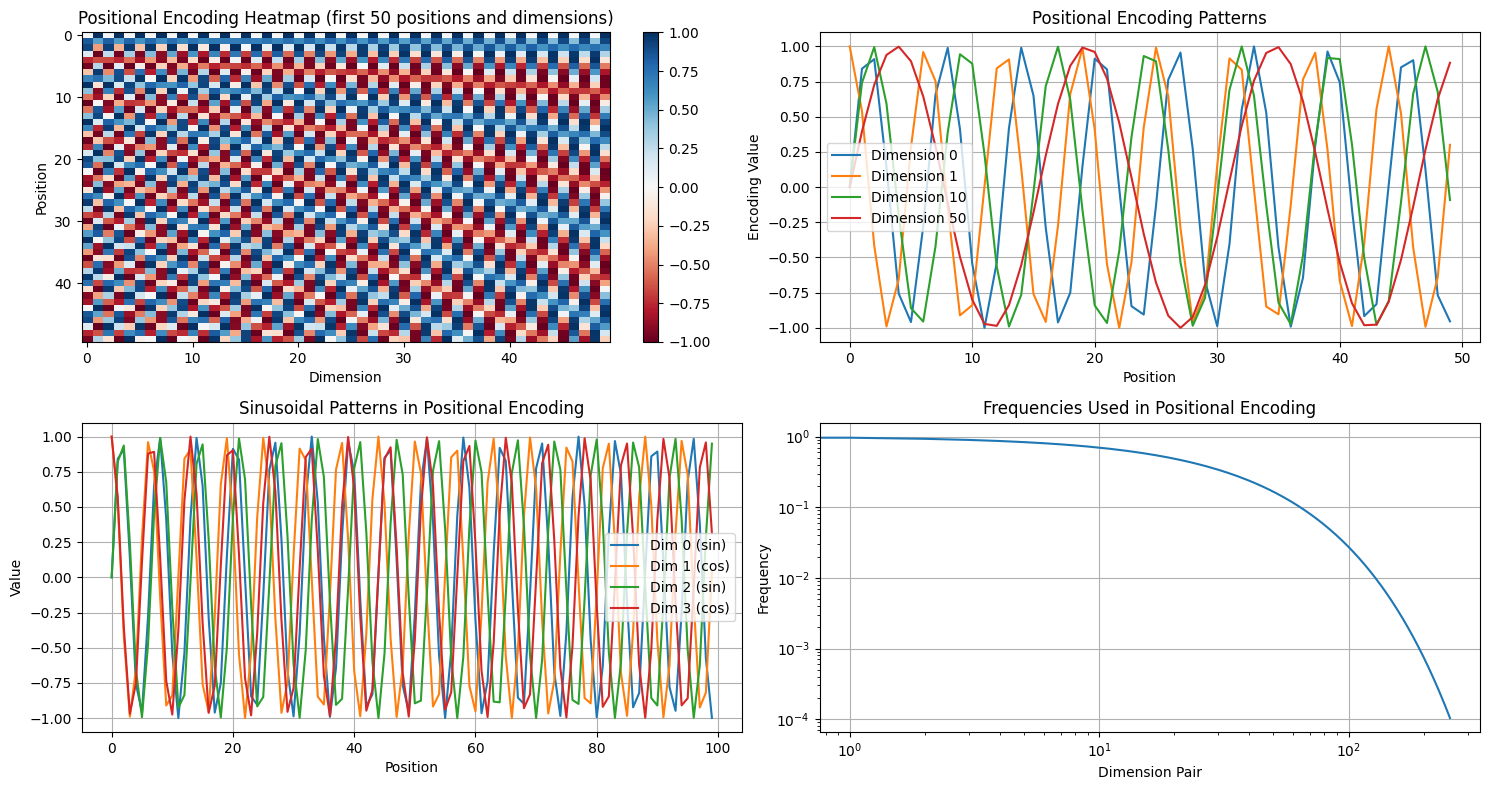

Why Positional Encoding is Crucial:
1. Transformers process all positions simultaneously
2. Without position info, 'cat sat on mat' = 'mat on sat cat'
3. Sinusoidal encoding allows the model to attend to relative positions
4. Different frequencies encode position at different scales


=== Understanding Attention Mechanism ===



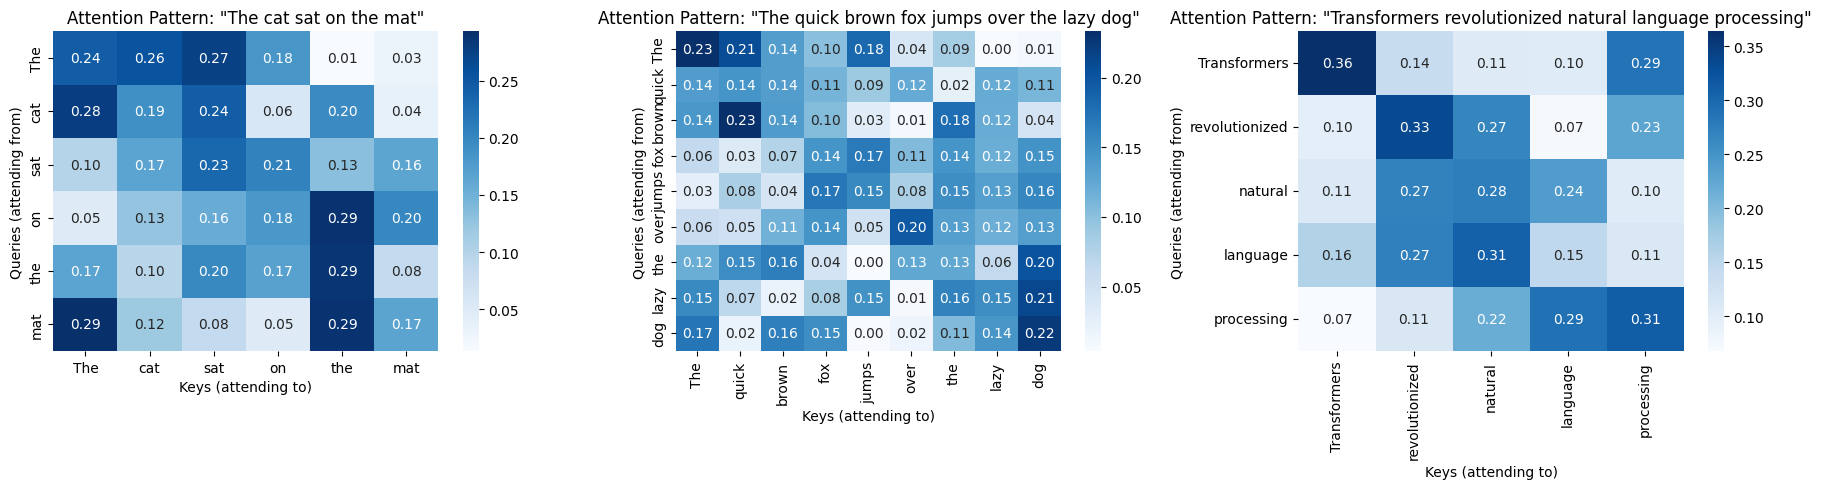

Key Insights from Attention Visualization:
1. Each word (query) attends to all words (keys) with different weights
2. Attention weights sum to 1 for each query
3. The model learns which words are relevant to each other
4. This allows capturing long-range dependencies

🎉 Transformer Foundation Complete!
You now understand the architecture that powers GPT, BERT, and more!


In [17]:
if __name__ == "__main__":
    print("Starting Transformer Architecture Deep Dive...\n")
    
    # Run educational components
    transformer_learning_path()
    print("\n" + "="*60 + "\n")
    
    compare_architectures()
    print("="*60 + "\n")
    
    demonstrate_positional_encoding()
    print("="*60 + "\n")
    
    visualize_attention_patterns()
    
    print("🎉 Transformer Foundation Complete!")
    print("You now understand the architecture that powers GPT, BERT, and more!")